<img src="Airbnb_Logo1.png" width="300" height="100">

### Capstone Project 
#### Project Title: Using Machine Learning to develop a recommendation system for London neighbourhoods
#### Student Name: Zinia Bhattacharya
#### Notebook 3: Modelling Part 1

------------------------------------------------------------------

#### Summary of Modelling approach and outcome - Part 1

This being an unsupervised NLP project, processing the text data in the right way to then test the outcome against different models was the basis of our machine learning task.

**Steps in text processing and modelling:**<br>
(1) Cleaning and preparing the text data for modelling:<br>
--(a) Removing strings<br>
--(b) Defining functions to process text data - remove punctuation, convert to lower case, apply stemming and lemmatization<br>
--(c) Defining function for custom tokenizer that applies relevant text processing from the revious step<br>

(2) Topic modelling with LDA (Latent Dirichlet Allocation)<br>
(3) KMeans modelling on vectorized data- Count Vectorizer and TFIDF<br>
(4) Wordembedding on sample dataset of 500 rows<br>
(5) KMeans modelling on sample dataset<br>


**Overview of the modelling outcomes:**<br>

<u>LDA</u> <br>
LDA was our first choice because of its ability to infer the underlying topics and their associated word distributions from the observed documents. We applied LDA in our project to model the distribution of words in the document 'neighborhood_overview`. 

The LDA model has performed relatively well in allocating neighborhood descriptions broadly across 5 profiles based on frequency of suburb names, proximity to specific attractions and a few unique descriptions of the neighborhood e.g. trendy. However, this also proves to be a drawback because the profile allocation appears to be very mildly related to characteristics or vibe of the suburb itself. 

This is likely not a failing of the model itself but its application on the `neighborhood description` which are probably meant to highlight proximity to tourist attractions as opposed to the innate vibe of the neighbourhood. The LDA model is still a very effective way to profile different neighborhoods in London to inform the recommendation as a base model.


<u>KMeans with TF-IDF</u> <br>
We also explored KMeans model with TF-IDF vectorizer but the results were not very encouraging as the clusters had a fair amount of overlap and not particularly distinct.

<u>KMeans with sentence embedding - distilBERT</u> <br>
We then applied word-embedding, given their proven effectiveness in NLP tasks. We used the distilBERT embedding model which is pretrained for sentence embedding and we tested it on a small subset of our dataframe. The results, although not enirely robust, are encouraging as we can start to see some distinct neighbourhood profiles.<br>
In conclusion, KMeans with word-embedding appears to work better than the other models and can result in clearer clusters with more fine-tuning of the corpus.

In [38]:
#importing relevant packages

import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# stats

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, re, TfidfVectorizer
from sklearn.feature_extraction.text import strip_accents_ascii, strip_accents_unicode, strip_tags

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import silhouette_score
np.random.seed(12345)

import warnings
warnings.filterwarnings('ignore')


#### Modelling - Part 1

#### Analyzing text data from `neighbourhood_overview` and `name` columns


In [39]:
#importing text processing pacakges and relevant models

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *


print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [58]:
#loading data
df=joblib.load('C:\\Users\\Zinia\\Documents\\capstone-project-ZiniaB\\Data\\df_suburb_clean.pkl')

Vectorizing text column `neighborhood_overview`

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40605 entries, 0 to 2562
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      40605 non-null  int64  
 1   name                    40605 non-null  object 
 2   neighborhood_overview   40605 non-null  object 
 3   London_borough          40605 non-null  object 
 4   latitude                40605 non-null  float64
 5   longitude               40605 non-null  float64
 6   minimum_nights          40605 non-null  int64  
 7   property_type           40605 non-null  object 
 8   room_type               40605 non-null  object 
 9   price                   40605 non-null  object 
 10  review_scores_location  40605 non-null  float64
 11  suburb                  40605 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 4.0+ MB


In [64]:
#creating a combined string of strings that need to be removed from the text analysis of `neighborhood_overview`. <br> was likely used to split the sentences and can cause issues with our analysis unless removed
pattern = '|'.join(['br', ' br', '>br', '><br', 'br br br', '/><br', '/<br', '<br', 'br br', '/>'])
pattern

'br| br|>br|><br|br br br|/><br|/<br|<br|br br|/>'

In [65]:
#removing the above patterns from the text in `neighborhood_overview`
df['neighborhood_overview'] = df['neighborhood_overview'].str.replace(pattern,'')

In [66]:
#viewing one row to see if the amends have now been applied
df['neighborhood_overview'].loc[5]

5    Location, location, location! You won't find b...
5    The flat is located in the former historic cor...
Name: neighborhood_overview, dtype: object

In [52]:
#defining function to remove punctuation
def remove_punctuation(document, punc):
    '''
    Removes punctuation provided (string) from document (string)
    '''
    document = re.sub(f"\{punc}", '', document)
    
    return document


In [53]:
#defining function to remove punctuation variation
def remove_all_punctuation(document):
    '''
    Removes all punctuation (found in string.punctuation) from document (string)
    '''
    
    for punc in string.punctuation:
        document = remove_punctuation(document, punc)
    
    return document

In [54]:
#defining function to remove stopwords
def remove_stopwords(list_of_tokens):
    """
    Literally removes stopwords
    """
    
    stop_words = stopwords.words('english')

    cleaned_tokens = [] 
    
    for token in list_of_tokens: 
        if token not in stop_words: 
            cleaned_tokens.append(token)
            
    return cleaned_tokens

In [55]:
#defining function to apply stemming

def stemmer(list_of_tokens):
    '''
    Takes in an input which is a list of tokens, and spits out a list of stemmed tokens.
    '''
    
    stemmed_tokens_list = []
    
    for i in list_of_tokens:
        token = PorterStemmer().stem(i)
        stemmed_tokens_list.append(token)
        
    return stemmed_tokens_list

In [56]:
#defining function to apply lemmatization
def lemmatizer(list_of_tokens):
    
    lemmatized_tokens_list = []
    
    for i in list_of_tokens: 
        token = WordNetLemmatizer().lemmatize(i)
        lemmatized_tokens_list.append(token)
        
    return lemmatized_tokens_list

In [57]:
#defining function for custom tokenizer that applies custom text processing

def my_tokenizer(document, lemmatization=True, stemming=False):
    '''
    Function for use in Vectorizer that tokenizes the document
    '''
    # lowercase
    document = str.lower(document)
    # remove punctuation
    document = remove_all_punctuation(document)
    
   
    # tokenize - split on whitespace
    tokenized_document = document.split(' ')
    # remove stopwords
    tokenized_document = remove_stopwords(tokenized_document)
    # lemmatization
    if lemmatization:
        tokenized_document = lemmatizer(tokenized_document)
    # stemming
    if stemming:
        tokenized_document = stemmer(tokenized_document)
        
    return tokenized_document

#### LDA Topic modelling

<u>Latent Dirichlet Allocation</u> model is usually used in topic modelling. Here we have applied it to model the distribution of words in the document 'neighborhood_overview`. The intuition behind LDA is that each document in a corpus is a mixture of several topics, and each topic is a probability distribution over words used to describe the topic. LDA was our first choice because of its ability to infer the underlying topics and their associated word distributions from the observed documents <br>
 
We will use the <u>Gensim</u> library for LDA topic modelling. Gensim stands for “Generate Similar” and is a popular open source natural language processing library used for unsupervised topic modeling. We will also be using the <u>pylDavis</u> library for visualizing and interpreting the topics in the LDA model.


Reference sources:

https://www.analyticsvidhya.com/blog/2022/08/supervised-topic-models/?utm_source=reading_list&utm_medium=https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/
https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb <br>
https://radimrehurek.com/gensim/models/ldamodel.html <br>
https://pyldavis.readthedocs.io/en/latest/modules/API.html


In [130]:
# preparing processed text by applying my_tokentizer to vectorize the data and removing blank strings from the text
processed_text = df['neighborhood_overview'].apply(lambda row: my_tokenizer(row))
processed_text.str.replace(' ','')
processed_text

0        [finsbury, park, friendly, melting, pot, commu...
1                                                [chelsea]
2        [neighbourhood, victoria, park, village, absol...
3        [unique, cinema, called, phoenix, supposed, ol...
4        [location, location, location, wont, find, bet...
                               ...                        
40600    [quiet, neighbourhood, away, hustle, bustle, e...
40601    [aside, iconic, stadium, sse, arena, youll, ex...
40602    [home, london, iconic, concert, event, venue, ...
40603    [aside, iconic, stadium, sse, arena, youll, ex...
40604    [home, london, iconic, concert, event, venue, ...
Name: neighborhood_overview, Length: 40605, dtype: object

In [71]:
# defining the dictionary with the gensim library.
# corpora - multiple corpus 

dictionary = gensim.corpora.Dictionary(processed_text)

In [72]:
'''
Removing very rare and very common words:
- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [73]:
#document in bag of words format
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_text]

In [95]:
# LDA multicore uses all CPU cores to speed up model training and the below code uses 2 workers
# num_topics (int, optional) – The number of requested latent topics to be extracted from the training corpus.
# id2word ({dict of (int, str), gensim.corpora.dictionary.Dictionary}) – Mapping from word IDs to words. 
# passes - number of passes through the corpus during training

'''
Training the lda model using gensim.models.LdaMulticore and saving it to 'lda_model'
'''
# 
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 5, 
                                   id2word = dictionary,
                                   random_state=21,                                    
                                   passes = 10,
                                   workers = 2)

In [105]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Neighborhood_Profile: {} \nWords: {}".format(idx, topic ))
    print("\n")

Neighborhood_Profile: 0 
Words: 0.027*"museum" + 0.011*"british" + 0.009*"camden" + 0.008*"marylebone" + 0.008*"visit" + 0.008*"find" + 0.008*"head" + 0.007*"like" + 0.007*"hill" + 0.007*"italian"


Neighborhood_Profile: 1 
Words: 0.014*"line" + 0.013*"train" + 0.012*"access" + 0.010*"transport" + 0.009*"residential" + 0.009*"palace" + 0.009*"mile" + 0.008*"west" + 0.008*"location" + 0.008*"court"


Neighborhood_Profile: 2 
Words: 0.006*"community" + 0.006*"family" + 0.005*"art" + 0.005*"viant" + 0.005*"offer" + 0.005*"building" + 0.005*"new" + 0.005*"space" + 0.005*"best" + 0.005*"make"


Neighborhood_Profile: 3 
Words: 0.023*"kensington" + 0.013*"river" + 0.013*"museum" + 0.013*"hyde" + 0.012*"royal" + 0.012*"bridge" + 0.011*"thames" + 0.011*"tower" + 0.010*"hill" + 0.010*"notting"


Neighborhood_Profile: 4 
Words: 0.012*"coffee" + 0.009*"hackney" + 0.007*"east" + 0.007*"shoreditch" + 0.007*"brixton" + 0.006*"canal" + 0.006*"nice" + 0.006*"cinema" + 0.006*"lane" + 0.006*"plenty"




Interpreting the profiles:

The most dominant words within a topic or profile in this case, have the highest weighting/scores but looking at the above, we can see that there are variations in the scores across profiles but also within the same neighbourhood profile. e.g. Profile 0 has a weighting of 0.027 for 'Museum' but it drops to 0.011 for the next word -'British'. Looking at Profile 2, however, we can see that the weighting across all words are lower and all within the 0.005-0.006 range suggesting that there were no words that were distinctly dominant in this profile.

But we can start to see a few patterns emerging on the profiles of the neighborhoods which we will explore further with the visualization below

Note: The LDA vizualization below can differ slightly from the model output above, despite specifying the same random seed.

In [112]:
# Fix random seed
import random
random.seed(21) #adding random seed to prevent the vizualization to differ signifucantly each time the cell is run
np.random.seed(21) #adding random seed to prevent the vizualization to differ signifucantly each time the cell is run
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary,sort_topics=False) #Setting the sort_topics parameter to False to esnure that the topic order remains consistent across different runs
pyLDAvis.display(vis)

The LDA model has performed relatively well in allocating neighbourhood descriptions broadly across 5 profiles based on frequency of suburb names, proximity to specific attractions and unique descriptions of the neighborhood e.g. trendy

Profile 1: Tourist attractions and restaurants <br>
Profile 2: Neighbourhoods with easy transport accessibility <br>
Profile 3: Family friendly, community feel<br>
Profile 4: Tourist hub and riverside neighbourhoods <br>
Profile 5: Trendy, independent cafes, nightlife suburbs <br>


Challenges with the model:
In our LDA model, we have not used bi-gram or tri-grams and it has only modelled on a single word basis ( e.g. spaces, open and green - all evaluated separately) as running with bi-grams is computationally expensive. But the absence of bi-grams and tri-grams might have impacted the accuracy and interpretability of the profile allocation <br>

The allocation is also highly dependent on the occurence of different words within the `neighborhood_overview` and it may not be able to assess the context of the words necessarily e.g. a description for a property located in Dulwich suggesting that it is only a 20 minute train ride to London Bridge and the river, might lead the model to allocate Dulwich to neighbourhood profile that have riverside location (hypothetical example)

Overall, the LDA model is a very good baseline model to start profiling the neighborhoods but we will explore further models that can go beyond uni-word analysis and account for context, where possible.

#### KMeans Clustering with TFIDF


Here we are doing to vectorize the data by applying CountVectorizer and then TF-IDF to see if there are any differences in the top tokens as per the two methods. Both methods are used to covert text data to vectors but each slightly different in their approach.<br>
CountVectorizer simply counts the number of times a word appears in a document, while TF-IDF (Term Frequency Inverse Document Frequency) takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.This is done by penalizing words that appear frequently across the corpus but attaching higher importance to words that occur more frequently within the document itself.

We will use the TF-IDF ventorized data for our KMeans modelling, as it takes into account the relative importance of the tokens as well.


In [91]:
#Vectorizing text data with custom tokenizer defined previously
#specifying ngram range as (1,2), limiting maximum features to 1000 and accounting for terms which occur in at least more than 5 documents
vectorizer = CountVectorizer(tokenizer=my_tokenizer, ngram_range=(1, 2), max_features=2000, min_df=5)
bagofwords = vectorizer.fit(df.loc[:,'neighborhood_overview']) #fitting the vetorizer on all rows of 'neighborhood_overview

In [113]:
#vectorizing the data
n_cv_transformed= bagofwords.transform(df.loc[:,'neighborhood_overview'])

In [114]:
#returning array for the vectorized data
n_cv_transformed.toarray()

array([[3, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

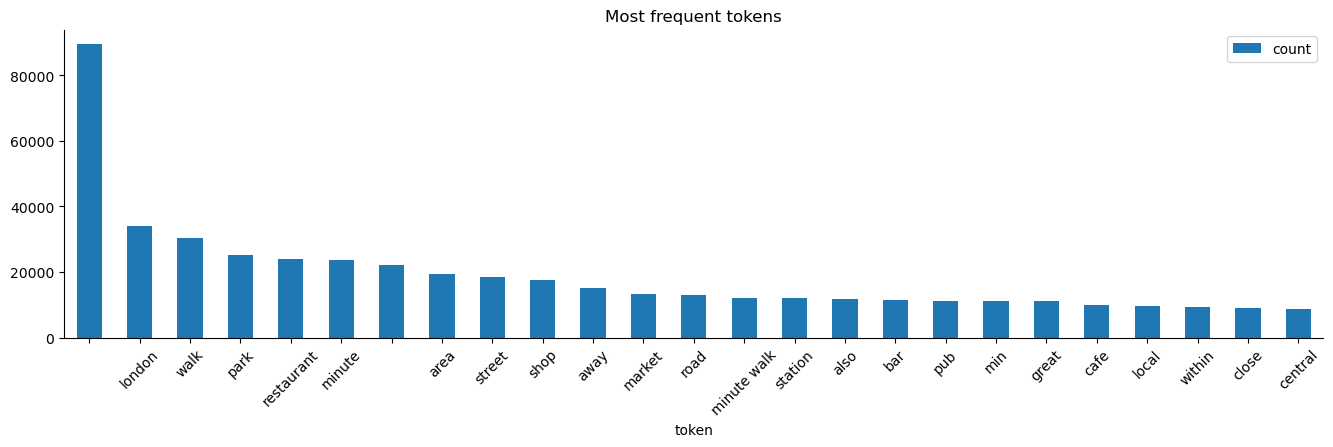

In [115]:
# Plotting the graph to vizualize top occuring terms

word_counts = n_cv_transformed.toarray().sum(axis=0)
words =bagofwords.get_feature_names_out()

def plot_most_frequent(words, word_counts, top=25):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.65*top,4))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token").plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens-Count Vectorizer")
    plt.show()
    
plot_most_frequent(words, word_counts)

Note: Blank string to be disregarded.

Looking at the above plot, as one could expect, we can see that parks, restaurants, shops, markets come up as most frequently occuring terms in neighbourhood description. At the outset, they appear to be common words without any distinct neighbourhood charactersistics jumping out.

In [117]:
#Vectorizing text data with custom tokenizer defined previously
#specifying ngram range as (1,3), limiting maximum features to 2000 and accounting for terms which occur in at least more than 5 documents
tfidf = TfidfVectorizer(tokenizer=my_tokenizer, ngram_range=(1, 3), max_features=2000, min_df=5)
tfidf_bagofwords = vectorizer.fit(df.loc[:,'neighborhood_overview'])

In [118]:
#vectorizing the data
t_transformed= tfidf_bagofwords.transform(df.loc[:,'neighborhood_overview'])

In [119]:
#eturning array for the vectorized data
t_transformed.toarray()

array([[3, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [123]:
tf_df = pd.DataFrame(columns=tfidf_bagofwords.get_feature_names_out(), data=t_transformed.toarray())

In [124]:
tf_df.head()

,,,1,10,15,2,20,3,4,5,...,you’ll find,you’re,zone,zone 1,zone 2,zoo,·,–,•,✔
0,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


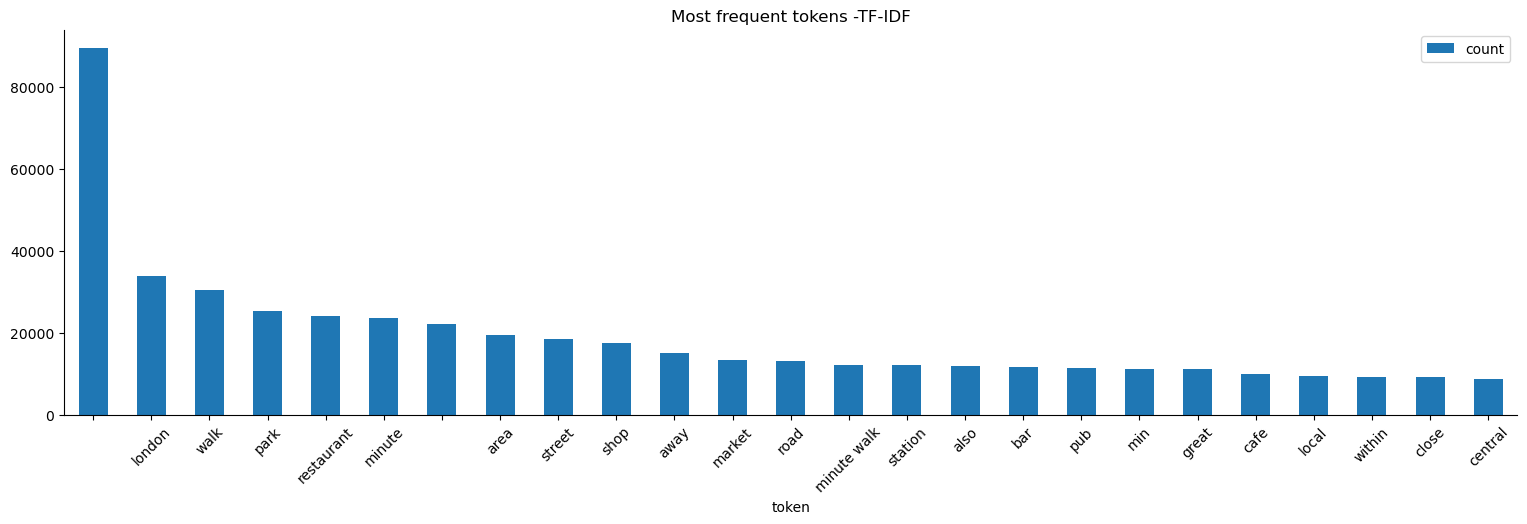

In [125]:
word_counts = t_transformed.toarray().sum(axis=0)
words =tfidf_bagofwords.get_feature_names_out()

def plot_most_frequent(words, word_counts, top=25):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.75*top, 5))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token").plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens -TF-IDF")
    plt.show()
    
plot_most_frequent(words, word_counts)

Note: Blank string to be disregarded.

Similar to Count Vectorizer, we can see that parks, restaurants, shops, markets come up as most frequently occuring terms in neighbourhood description. 

We will go ahead and run the KMeans model on the full dataset as our next approach to clustering the London neighbourhoods after the LDA model


In [126]:
#Combining the vectorized Dataframe with original dataframe prior to running KMeans
df.index = tf_df.index
df=pd.concat([df,tf_df], axis=1)
df.head(10)

,id,name,neighborhood_overview,London_borough,latitude,longitude,minimum_nights,property_type,room_type,price,...,you’ll find,you’re,zone,zone 1,zone 2,zoo,·,–,•,✔
0,13913,Holiday London DB Room Let-on going,Finsbury Park is a friendly melting pot commun...,Islington,51.568610,-0.112700,1,Private room in rental unit,Private room,$79.00,...,0,0,0,0,0,0,0,0,0,0
1,15400,Bright Chelsea Apartment. Chelsea!,It is Chelsea.,Kensington and Chelsea,51.487800,-0.168130,10,Entire rental unit,Entire home/apt,$75.00,...,0,0,0,0,0,0,0,0,0,0
2,173082,The Residential Suite Above Gallery,"The neighbourhood ""Victoria Park Village"" is a...",Hackney,51.538254,-0.044086,2,Entire rental unit,Entire home/apt,$132.00,...,0,0,0,0,0,0,0,0,0,0
3,42010,You Will Save Money Here,We have a unique cinema called the Phoenix whi...,Barnet,51.585900,-0.164340,4,Private room in home,Private room,$65.00,...,0,0,0,0,0,0,0,0,0,0
4,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Location, location, location! You won't find b...",Westminster,51.521950,-0.140940,4,Entire rental unit,Entire home/apt,$425.00,...,0,0,0,0,0,0,0,0,0,0
5,42692,Fabulous flat w garden and bkfst!,The neighborhood of Holland Park borders Notti...,Hammersmith and Fulham,51.508220,-0.215620,1,Private room in rental unit,Private room,$125.00,...,0,0,0,0,0,0,0,0,0,0
6,43129,Quiet Comfortable Room in Fulham,The area is called Munster village. It has a ...,Hammersmith and Fulham,51.481640,-0.210820,3,Private room in townhouse,Private room,$60.00,...,0,0,0,0,0,0,0,0,0,0
7,43202,Beautiful 1 bed apt in Queens Park,It's a really safe and friendly neighbourhood....,Brent,51.530310,-0.217130,4,Entire rental unit,Entire home/apt,$141.00,...,0,0,0,0,0,0,0,0,0,0
8,174132,Large Bedroom with EnSuite Bathroom,its near Little Venice with all the canals and...,Westminster,51.526360,-0.188010,1,Private room in rental unit,Private room,$83.00,...,0,0,0,0,0,0,0,0,0,0
9,179312,Lovely 1 bed Apartment Islington on Tube Stop,Yes Arsenal Football Stadium is a stones throw...,Islington,51.551910,-0.114970,2,Entire condo,Entire home/apt,$45.00,...,0,0,0,0,0,0,0,0,0,0


In [131]:
joblib.dump(df,'../Data/df_vec.pkl',compress =9)

['../Data/df_vec.pkl']

In [132]:
df=joblib.load('../Data/df_vec.pkl')

#### KMeans base model with TFIDF

In [134]:
#Running Kmeans with TFIDF and max 100 iterations

true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(tf_df)

KMeans(max_iter=100, n_clusters=5, n_init=1)

In [138]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_bagofwords.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")


Top terms per cluster:
Cluster 0:
 
 london
 walk
 minute
 park
 restaurant
  
 street
 area
 shop
Cluster 1:
 
  
 restaurant
 city
 nearby
 london
  nearby
 fish
 visit
 indian restaurant
Cluster 2:
 london
 
 park
 walk
 restaurant
 area
 street
 minute
 shop
 away
Cluster 3:
 
  
 km
 walk
 museum
 london
 walk 
 museum 
 station
 euston
Cluster 4:
 
  
 walk
 minute
 london
 restaurant
 min
 park
 minute walk
 away




The KMeans model did not perform too well in terms of creating distinct clusters of neighbourhood characteristics.

Looking at the top terms per cluster, we could see a lot of overlap across clusters leading us to the conclusion that KMeans on TF-IDF isn't the right model for our dataset. 

Top terms per cluster:
Cluster 0: bayswater, yet, garden, store, queensway, palace, london’s, london, area, park<br>
Cluster 1: london, walk, park, restaurant, minute, area, street, shop, away<br>
Cluster 2: restaurant, nearby, city, london, nearby, centre london, england<br>
Cluster 3: walk, museum, euston, walk, london, road, walk<br>
Cluster 4: walk, london, minute, park, restaurant, min, away, minute walk

#### KMeans with word embedding

As a next step, we looked into word-embeddings to enhance our clustering model. 

Word embeddings like BERT (Bidirectional Encoder Representations from Transformers) are proven be very effective in Natural Language Processing as they are able to capture the semantic meaning and contextual relationships of the words. 

For our project, we have applied 'Distilbert-base-nli-mean-tokens' embedder. It is a pre-trained language model that is based on the DistilBERT architecture, which is a smaller and faster version of the BERT model. This model is specifically trained for sentence embeddings, which are dense numerical representations of sentences that capture their semantic meaning.

The "nli" in the name stands for "natural language inference", that determines the relationship between two sentences: whether the second sentence contradicts, entails, or is neutral with respect to the first sentence. The "mean-tokens" refers to the way in which sentence embeddings are generated by this model: by taking the mean (or average) of the individual token embeddings of the input sentence. By taking the mean of the token embeddings, DistilBERT-base-nli-mean-tokens is able to generate a fixed-length sentence embedding regardless of the length of the input sentence. This allows it to be used in a variety of downstream NLP tasks, such as sentence similarity, text classification, and information retrieval.

*Source: ChatGPT*<br>
*Source: https://www.sbert.net/docs/training/overview.html*<br>

We will go ahead and test the model on a small slice of the dataset - 500 rows

In [139]:
#Testing word embedding on Test df - 500 rows
df_test = df.sample(500)

Embedding algorithm - Distilbert base nli-mean-tokens

In [140]:
#importing distilbert sentence embedder
import os
from sentence_transformers import SentenceTransformer
embedder= SentenceTransformer('distilbert-base-nli-mean-tokens')

In [141]:
#defining the corpus
corpus = list(df_test['neighborhood_overview'])

**We have commented out a few lines of code below due to the computational time.The dataset can be loaded as a pkl further down**

In [145]:
#running the sentence embedder on our corpus
corpus_embeddings = embedder.encode(corpus)

In [146]:
corpus_embeddings

array([[-0.33627608, -0.48912862,  0.76027256, ...,  0.9936704 ,
        -0.14403285, -0.7369591 ],
       [ 0.5350101 , -0.37343028,  1.3616775 , ..., -0.04103872,
        -0.30849567, -0.38864025],
       [ 0.10479975, -0.13596159,  1.0335513 , ...,  0.19680725,
        -0.06141438, -0.595301  ],
       ...,
       [-0.53314227, -0.5217853 ,  0.78673524, ...,  0.27476168,
        -0.09427706, -0.25990948],
       [-0.35489216, -0.48895556,  0.06916641, ...,  0.7396374 ,
        -0.54524285, -0.60818154],
       [-0.11705527, -0.09724892,  1.3895526 , ...,  0.3285606 ,
        -0.16174813, -0.75116575]], dtype=float32)

In [147]:
#Running KMeans with 6 clusters

num_clusters = 6
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [158]:
cluster_df = pd.DataFrame(corpus, columns = ['corpus'])
cluster_df['cluster']=cluster_assignment
cluster_df.head()

,corpus,cluster
0,"Safe, clean, quiet neighbourhood. Great access...",4
1,"Kensington - central, beautiful :) - Lost of g...",2
2,Home to London’s most remarkable and historic ...,5
3,Our flat is higher ground floor. ( can be call...,3
4,Beautiful neighbourhood. Restaurant and cafe w...,0


In [159]:
cluster_df.shape

(500, 2)

In [160]:
joblib.dump(cluster_df,'../Data/df_cluster_embed_test.pkl',compress =9)

['../Data/df_cluster_embed_test.pkl']

In [161]:
cluster_df=joblib.load('../Data/df_cluster_embed_test.pkl')

In [162]:
cluster_df.shape

(500, 2)

In [163]:
#concatenating the embedding df with the test dataframe
df_test.index=cluster_df.index
df_check=pd.concat([df_test,cluster_df], axis=1)

In [111]:

cluster1_df=df_check.loc[df_check['cluster']==1]

**Visualizing the key words in each cluster with word clouds**<br>
We will look at the cluster terms to see if there are any distinct neighbourhood characteristics that are being clustered together

In [172]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [170]:
cluster1_df=df_check.loc[df_check['cluster']==1]
Cluster1_text = " " .join(cat for cat in cluster1_df['corpus'])

In [176]:
stopwords = STOPWORDS
cluster1_word_cloud = WordCloud(width=3000, height=2000,random_state=1, collocations=False,stopwords=stopwords).generate(Cluster1_text)


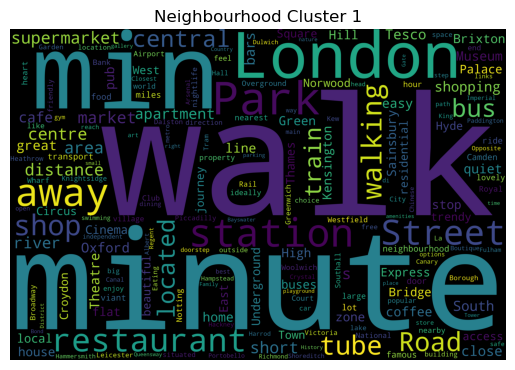

In [177]:
plt.imshow(cluster1_word_cloud)
plt.axis("off")
plt.title('Neighbourhood Cluster 1')
plt.show()


Cluster 1: Accesibility to transport hubs appear to be the key characteristic

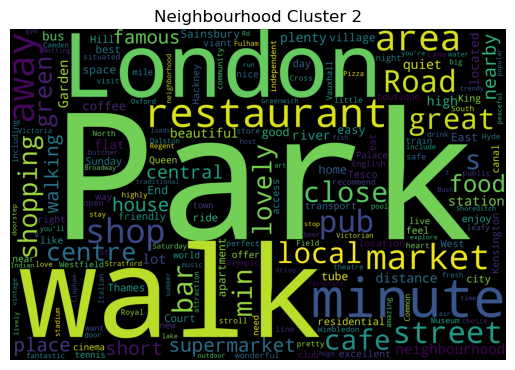

In [178]:
#WordCloud for Cluster 2
cluster2_df=df_check.loc[df_check['cluster']==2]
Cluster2_text = " " .join(cat for cat in cluster2_df['corpus'])
cluster2_word_cloud = WordCloud(width=3000, height=2000,random_state=1, collocations=False,stopwords=stopwords).generate(Cluster2_text)
plt.imshow(cluster2_word_cloud)
plt.axis("off")
plt.title('Neighbourhood Cluster 2')
plt.show()


Cluster 2 : Parks, walks and short distance to restaurants and markets

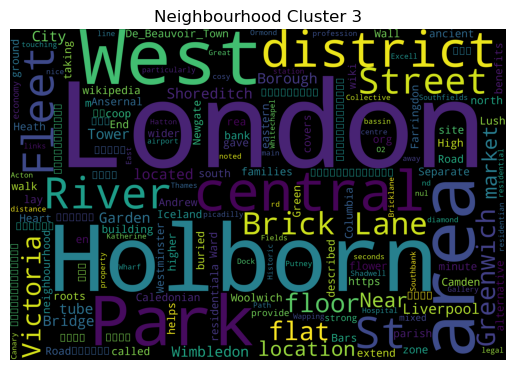

In [179]:
#WordCloud for Cluster 3
cluster3_df=df_check.loc[df_check['cluster']==3]
Cluster3_text = " " .join(cat for cat in cluster3_df['corpus'])
cluster3_word_cloud = WordCloud(width=3000, height=2000,random_state=1,stopwords=stopwords).generate(Cluster3_text)
plt.imshow(cluster3_word_cloud)
plt.axis("off")
plt.title('Neighbourhood Cluster 3')
plt.show()


Cluster 3: Central location or proximity to central London

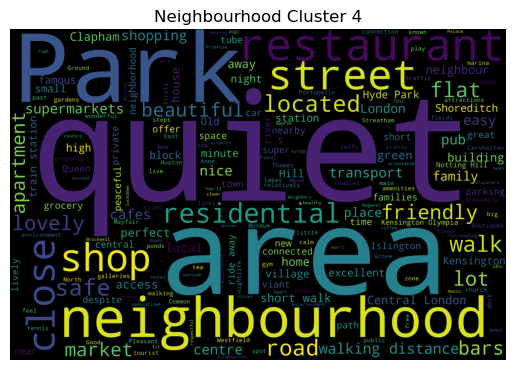

In [180]:
# WordCloud for Cluster 4
cluster4_df=df_check.loc[df_check['cluster']==4]
Cluster4_text = " " .join(cat for cat in cluster4_df['corpus'])
cluster4_word_cloud = WordCloud(width=3000, height=2000,random_state=1,stopwords=stopwords).generate(Cluster4_text)
plt.imshow(cluster4_word_cloud)
plt.title('Neighbourhood Cluster 4')
plt.axis("off")
plt.show()


Cluster 4: Neighbourhoods that are quiet, residential and close to parks

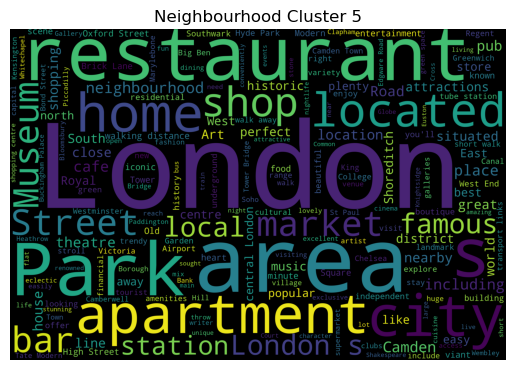

In [181]:
#WordCloud for Cluster 5
cluster5_df=df_check.loc[df_check['cluster']==5]
Cluster5_text = " " .join(cat for cat in cluster5_df['corpus'])
cluster5_word_cloud = WordCloud(width=3000, height=2000,random_state=1,stopwords=stopwords).generate(Cluster5_text)
plt.imshow(cluster5_word_cloud)
plt.axis("off")
plt.title('Neighbourhood Cluster 5')
plt.show()

Cluster 5: No clear characteristics coming out for this cluster

In [182]:
clustered_sentences = [[]for i in range (num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("cluster", 1+i)
    print (cluster)
    print("")

cluster 1
['Beautiful neighbourhood. Restaurant and cafe within walking distance. Close to shopping centre and train/tram stations.', "Eltham is a beautiful town with plenty to see and do. The people are friendly, there's architecture that ranges from the medieval period all the way up through Art Deco designs for those interested in design history as well--you'll find no shortage of things on your plate here!", "Ideal for adventurous guests. There are many things to do nearby. Surely, you won't get bored.", 'The neighborhood is lively and my nights and days are walking distances from the flat. All the best restaurants and bars are nearby, also parcs and shopping stores', 'Shoreditch is buzzing with the bars, restaurants and many things artistic.  The apartment is located on the city road - so please be aware this is a busy part of London.', 'Great and charming area with lots of music venues, restaurants, pubs, cafes, very close to big and awesome liaries (Wellcome, British and a range

**Summary**

In this notebook, we have covered Part 1 of our modelling work. We looked at LDA as a fairly good base model albeit with its limitations. We also looked at KMeans on TF-IDF vectorized data which did not prove effective in clustering the neighbourhood profiles. We then applied sentence-embedding with Distilbert on a small subset of the data and the results have been encouraging.

With word-embedding we can see more distinct neighbourhood clusters with charactersitics such as quiet and residential vs. busy shopping areas, amongst other differences. But word-embedding is computationally heavy. So we will follow a two-pronged approach for further fine-tuning of the clustering.

(1) In part 2 of our modelling work, we will layer in ChatGPT data for the neighbourhood profies of top 100 suburbs and run word-embedding and KMeans clustering<br>
(2) In part 3, we will run diltilbert on the full-dataset of airbnb listing's `neighborhood_overview`

In summary, the initial results from KMeans (with word-embedding) are encouraging and with more fine-tuning, we could have a more robust clustering model that can be extended to the remaining suburbs and potentially to other top global cities

--------------------------------------------------